# Introduction

This notebook is focused on the basics of using [MXNet](http://mxnet.io/) in [Julia](http://julialang.org/) to create a simple Multilayer Perceptron (MLP). This basic neural network building block is described more fully in [Wikipedia](https://en.wikipedia.org/wiki/Multilayer_perceptron).  

We will be making predictions on the famous MNIST data set, which is a labeled set of individual handwritten digits from zero to nine.  A brief description is available in [Wikipedia](https://en.wikipedia.org/wiki/MNIST_database). The data is available at http://yann.lecun.com/exdb/mnist/, where there are also descriptions of the effectiveness of the different approaches applied to this data and references to related papers.  Instead of this source, however, I will be using the data from [Kaggle](http://kaggle.com/) as I have learned a lot from the competitions there and like to use it as an example.

I also intend to use this as brief tutorial on looking at data using the [Julia](http://julialang.org/) language.  It assumes some basic knowledge of Julia, although someone who knows Python or R could probably figure it all out.

# Get data

You can get the data from https://www.kaggle.com/c/digit-recognizer/data.  The Kaggle website describes the files as follows:

>The data files `train.csv` and `test.csv` contain gray-scale images of hand-drawn digits, from zero through nine.

>Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

>The training data set, `train.csv`, has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

>Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).

>For example, pixel31 indicates the pixel that is in the fourth column from the left, and the second row from the top, as in the ascii-diagram below.

>Visually, if we omit the "pixel" prefix, the pixels make up the image like this:
```
000 001 002 003 ... 026 027
028 029 030 031 ... 054 055
056 057 058 059 ... 082 083
 |   |   |   |  ...  |   |
728 729 730 731 ... 754 755
756 757 758 759 ... 782 783 
```
The test data set, `test.csv`, is the same as the training set, except that it does not contain the "label" column.

>Your submission file should be in the following format: For each of the 28000 images in the test set, output a single line with the digit you predict. For example, if you predict that the first image is of a 3, the second image is of a 7, and the third image is of a 8, then your submission file would look like:

>3

>7

>8

>(27997 more lines)


Of course, we can learn a lot of this by just looking at the data. The code below assumes you downloaded the csv files and put them in a folder named `data`.

In [3]:
using DataFrames, CSV

A few comments for those new to Julia.  Most people start working with the REPL where the contents of any line you type is immediately evaluated and returned.  Working with Jupyter notebooks using iJulia allows the possibility of depicting such results graphically, and in the case of `DataFrames`, they are rendered in a nice tabular format.  In this case, by following the line with a semicolon, I will suppress the normal output as I don't want to potentially clutter the notebook with a table that has 42000 rows in it.  I encourage you to download this notebook and experiment with it, removing the semicolon and seeing what the raw data looks like.  Of course, you can use functions like `head()` and `tail()` as demonstrated in the [Stats](#Stats) section.

I am also using the `@time` macro here to as I like to track how long different processes take and memory involved.  You can delete the leading `@time` from any command line if you just want to execute the operation.

In [4]:
@time train = CSV.read("data/train.csv");

  6.867796 seconds (15.87 M allocations: 751.361 MiB, 6.01% gc time)


In [8]:
first(train, 6)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0


In [5]:
# to get the size/shape of the DataFrame
size(train)

(42000, 785)

In [16]:
# first element is label, rest is 28x28=784 pixel values, so to look at first row
reshape([train[1,col] for col in 2:785], 28, 28)

28×28 Array{Int64,2}:
 0  0  0  0    0    0    0    0    0  …    0    0    0    0    0  0  0  0  0
 0  0  0  0    0    0    0    0    0       0    0    0    0    0  0  0  0  0
 0  0  0  0    0    0    0    0    0       0    0    0    0    0  0  0  0  0
 0  0  0  0    0    0    0    0    0       0    0    0    0    0  0  0  0  0
 0  0  0  0    0    0    0    0    0       0    0    0    0    0  0  0  0  0
 0  0  0  0    0    0    0    0    0  …    0    0    0    0    0  0  0  0  0
 0  0  0  0    0    0    0    0    0       0    0    0    0    0  0  0  0  0
 0  0  0  0    0    0    0    0    0       0   15   94   89    0  0  0  0  0
 0  0  0  0    0    0    0    0    0      89  220  253  251  214  0  0  0  0
 0  0  0  0    0    0    0    0    0     240  253  253  253  218  0  0  0  0
 0  0  0  0    0    0    0    0    0  …  253  253  253  250   95  0  0  0  0
 0  0  0  0    0    0    0    0    0     195   80   94  131    0  0  0  0  0
 0  0  0  0    0    0    0    0    0      25    0    0

# Plot

There are several plotting libraries available for Julia. [Plots.jl](https://juliaplots.github.io/) is one of my favorites as it is developing an excellent ecosystem that allows multiple backends including [PyPlot](https://github.com/JuliaPy/PyPlot.jl) which is a wrapper around [Matplotlib](http://matplotlib.org/) and [Plotly](https://github.com/sglyon/PlotlyJS.jl) which is an interface to the [plotly.js](https://plot.ly/javascript) visualization library. Use StatPlots if you want to plot a DataFrame directly.

In [17]:
using Plots
# I like Plotly for interactivity.  
plotly(legend=false)
# to use it on GitHub, you have to setup Plotly Online and inject their code into the notebook
#  so just switch to PyPlot
pyplot()

┌ Info: Recompiling stale cache file /home/milton/.julia/compiled/v1.1/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1184


Plots.PyPlotBackend()

 12.920942 seconds (27.09 M allocations: 1.324 GiB, 7.05% gc time)


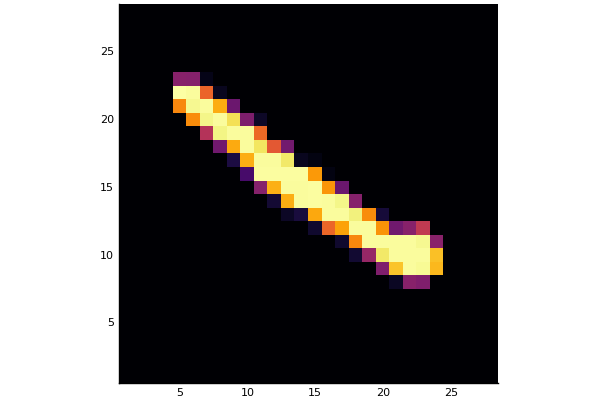

In [18]:
# heatmap() plots a 2D array
@time heatmap(reshape([train[1,col] for col in 2:785], 28, 28), aspect_ratio=:equal)

  0.071421 seconds (110.27 k allocations: 5.517 MiB)


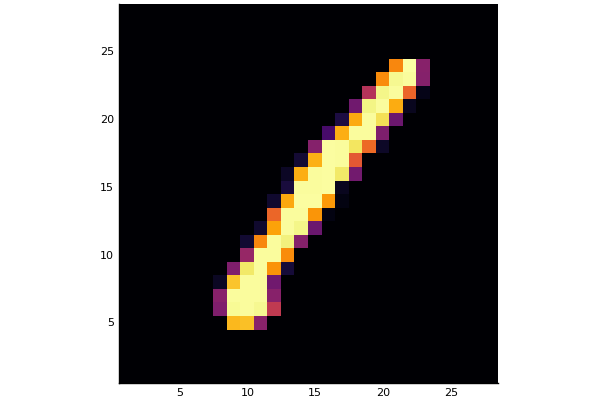

In [19]:
# to see it upright, use the rotl90() function to rotate left 90 degrees
# there are also rotr90() and rot180() functions
@time heatmap(rotl90(reshape([train[1,col] for col in 2:785], 28, 28)), aspect_ratio=:equal)

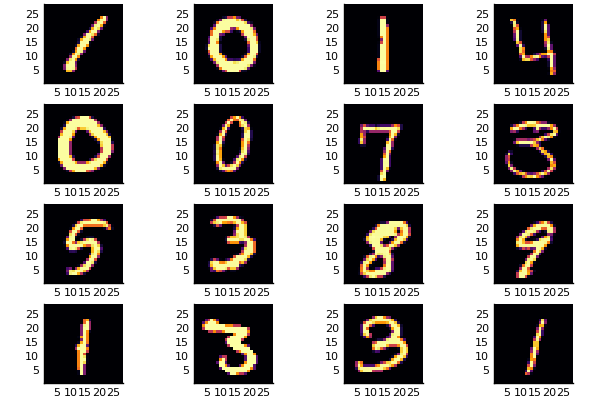

In [20]:
# we can use an array comprehension to plot the first sixteen rows
# the Plots library automatically resizes everything for you and adds the axes
plot([heatmap(rotl90(reshape([train[i,col] for col in 2:785], 28, 28)), aspect_ratio=:equal) for i=1:16]...)

# Stats

Now that we have confirmed that the data really are characters that are arranged as described in the data description, we will take a brief eyeball on the data just to make sure there is nothing strange.

In [21]:
# note that summary in Julia just gives basic information as it is supposed to work on ANY datatype
summary(train)

"42000×785 DataFrame"

In [22]:
# note that summary in Julia just gives basic information as it is supposed to work on ANY datatype
#  those who are used to R may be looking for the describe() function which is for DataFrames
describe(train)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Int64,Float64,Int64,Nothing,Nothing,DataType
1,label,4.45664,0,4.0,9,,,Int64
2,pixel0,0.0,0,0.0,0,,,Int64
3,pixel1,0.0,0,0.0,0,,,Int64
4,pixel2,0.0,0,0.0,0,,,Int64
5,pixel3,0.0,0,0.0,0,,,Int64
6,pixel4,0.0,0,0.0,0,,,Int64
7,pixel5,0.0,0,0.0,0,,,Int64
8,pixel6,0.0,0,0.0,0,,,Int64
9,pixel7,0.0,0,0.0,0,,,Int64


In [23]:
# the describe() function gives basic stats
# you could describe(train) to do the entire DataFrame, but that would take a lot of space here
describe(train[:,406])

Summary Stats:
Length:         42000
Missing Count:  0
Mean:           97.163476
Minimum:        0.000000
1st Quartile:   0.000000
Median:         35.000000
3rd Quartile:   231.000000
Maximum:        255.000000
Type:           Int64


In [25]:
# can also specify a column in a DataFrame with a Symbol
# Symbols in Julia have a colon before them and are reserved when created (:pixel404)
# I just just picked 404 because it is near the center for 28x28cv
describe(train[!, :pixel404])

Summary Stats:
Length:         42000
Missing Count:  0
Mean:           97.163476
Minimum:        0.000000
1st Quartile:   0.000000
Median:         35.000000
3rd Quartile:   231.000000
Maximum:        255.000000
Type:           Int64


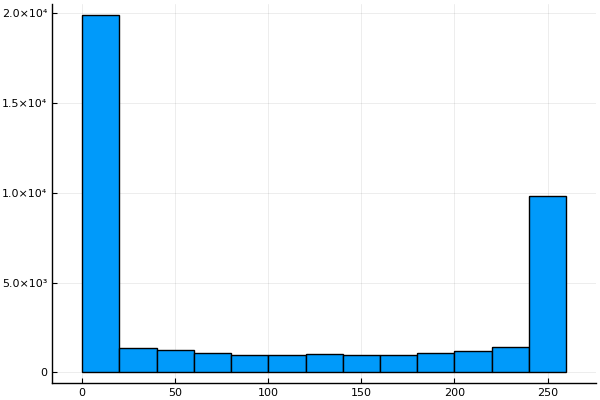

In [29]:
# see the distribution of values in that column
histogram(train[!, :pixel404], bins=20)

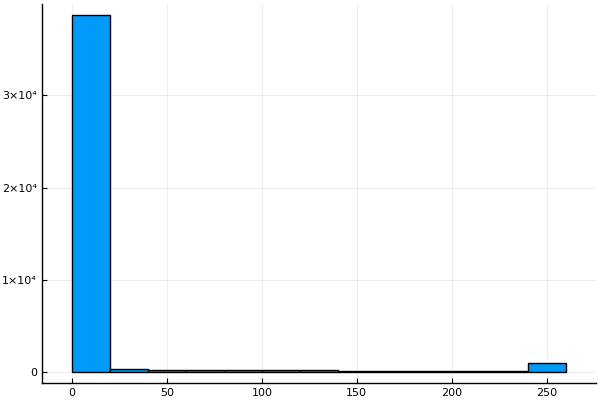

In [30]:
# a point a little more to the edge has a lot more zeros
histogram(train[!, :pixel397], bins=20)

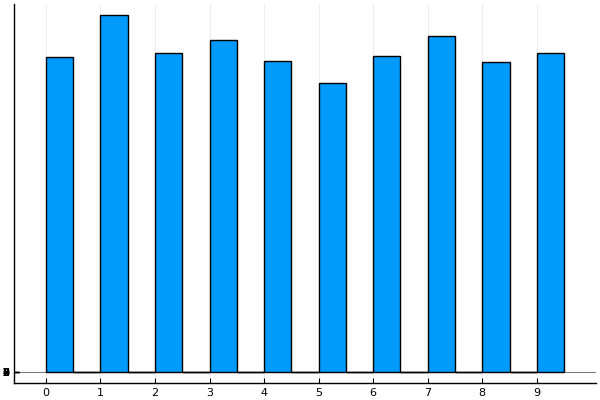

In [32]:
# distribution of labels - seems fairly even
histogram(train[!, :label], ticks=collect(0:9))

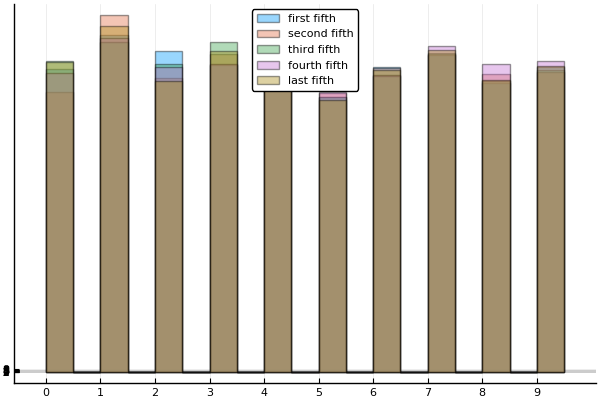

In [36]:
# we can plot different subsets to eyeball variation
histogram([train[1:8400,:label] train[8401:16800,:label] train[16801:25200,:label] train[25201:33600,:label] train[33601:end,:label]], ticks=collect(0:9), legend=true, 
label=["first fifth" "second fifth" "third fifth" "fourth fifth" "last fifth"], alpha=0.4)

If you really want to check stats, you might want to do a chi-square or Kolmogorov–Smirnov test to really see if the distribution is uniform.  You can do these with the [HypothesisTests](https://github.com/JuliaStats/HypothesisTests.jl) package in Julia.  Documentation is at https://juliastats.org/HypothesisTests.jl/stable/.  The real focus of this notebook is MLP, so let us move on and start setting it up.

# Preprocess data

In [43]:
? permutedims

search: permutedims permutedims! PermutedDimsArray



```
permutedims(A::AbstractArray, perm)
```

Permute the dimensions of array `A`. `perm` is a vector specifying a permutation of length `ndims(A)`.

See also: [`PermutedDimsArray`](@ref).

# Examples

```jldoctest
julia> A = reshape(Vector(1:8), (2,2,2))
2×2×2 Array{Int64,3}:
[:, :, 1] =
 1  3
 2  4

[:, :, 2] =
 5  7
 6  8

julia> permutedims(A, [3, 2, 1])
2×2×2 Array{Int64,3}:
[:, :, 1] =
 1  3
 5  7

[:, :, 2] =
 2  4
 6  8
```

---

```
permutedims(m::AbstractMatrix)
```

Permute the dimensions of the matrix `m`, by flipping the elements across the diagonal of the matrix. Differs from `LinearAlgebra`'s [`transpose`](@ref) in that the operation is not recursive.

# Examples

```jldoctest; setup = :(using LinearAlgebra)
julia> a = [1 2; 3 4];

julia> b = [5 6; 7 8];

julia> c = [9 10; 11 12];

julia> d = [13 14; 15 16];

julia> X = [[a] [b]; [c] [d]]
2×2 Array{Array{Int64,2},2}:
 [1 2; 3 4]     [5 6; 7 8]
 [9 10; 11 12]  [13 14; 15 16]

julia> permutedims(X)
2×2 Array{Array{Int64,2},2}:
 [1 2; 3 4]  [9 10; 11 12]
 [5 6; 7 8]  [13 14; 15 16]

julia> transpose(X)
2×2 Transpose{Transpose{Int64,Array{Int64,2}},Array{Array{Int64,2},2}}:
 [1 3; 2 4]  [9 11; 10 12]
 [5 7; 6 8]  [13 15; 14 16]
```

---

```
permutedims(v::AbstractVector)
```

Reshape vector `v` into a `1 × length(v)` row matrix. Differs from `LinearAlgebra`'s [`transpose`](@ref) in that the operation is not recursive.

# Examples

```jldoctest; setup = :(using LinearAlgebra)
julia> permutedims([1, 2, 3, 4])
1×4 Array{Int64,2}:
 1  2  3  4

julia> V = [[[1 2; 3 4]]; [[5 6; 7 8]]]
2-element Array{Array{Int64,2},1}:
 [1 2; 3 4]
 [5 6; 7 8]

julia> permutedims(V)
1×2 Array{Array{Int64,2},2}:
 [1 2; 3 4]  [5 6; 7 8]

julia> transpose(V)
1×2 Transpose{Transpose{Int64,Array{Int64,2}},Array{Array{Int64,2},1}}:
 [1 3; 2 4]  [5 7; 6 8]
```


In [46]:
@time a = convert(Matrix, train[:,2:end])

  1.337898 seconds (6.89 k allocations: 502.799 MiB, 54.34% gc time)


42000×784 Array{Int64,2}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0

In [47]:
@time transpose(a)

  0.134896 seconds (7.85 k allocations: 453.027 KiB)


784×42000 LinearAlgebra.Transpose{Int64,Array{Int64,2}}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  

In [ ]:
transpose(a) == permutedims(a)

In [49]:
@time permutedims(a)

  0.419683 seconds (6 allocations: 251.221 MiB, 1.94% gc time)


784×42000 Array{Int64,2}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0

In [41]:
# need to split train into training and eval sets
# convert DataFrame to an Array, remembering Julia is column-major like R and Matlab (unlike Python)
X = transpose(Array(train[:,2:end]))
y = Array(train[:,1])

MethodError: MethodError: no method matching Array(::DataFrame)
Closest candidates are:
  Array(!Matched::LinearAlgebra.SymTridiagonal) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.1/LinearAlgebra/src/tridiag.jl:111
  Array(!Matched::LinearAlgebra.Tridiagonal) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.1/LinearAlgebra/src/tridiag.jl:489
  Array(!Matched::LinearAlgebra.AbstractTriangular) at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.1/LinearAlgebra/src/triangular.jl:106
  ...

In [18]:
size(X)

(784,42000)

In [19]:
N = size(X)[2]

42000

In [20]:
length(y)

42000

In [21]:
extrema(X)

(0,255)

In [22]:
mean(X)

33.408911169825075

In [23]:
# scale X to range 0-1
X = X./255;

# Split data

In [24]:
# we need to split the train data into a training set (cv_X) and an eval set (eval_X)
split = 0.8
cv_X = X[:,1:floor(Int,split*N)]
eval_X = X[:,floor(Int,split*N)+1:N]

784×8400 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0

In [25]:
cv_y = y[1:floor(Int,split*N)]
eval_y = y[floor(Int,split*N)+1:N]

8400-element Array{Int64,1}:
 0
 7
 7
 2
 2
 6
 5
 7
 8
 5
 3
 0
 2
 ⋮
 0
 5
 3
 1
 9
 6
 4
 0
 1
 7
 6
 9

# Setup providers

Here we get to the heart of this notebook: setting up the problem in MXNet. Full documentation for the Julia `MXNet.jl` library is available at http://dmlc.ml/MXNet.jl/latest/.  Here is the big picture:

Neural networks in MXNet are set up as Models.  Presently there are only Feedforward models that you define with the [Symbolic API](http://dmlc.ml/MXNet.jl/latest/api/symbolic-node/). The model is fed data through a Data Provider.  The `fit()` or `train()` function trains a Model with a Data Provider with a chosen Optimizer, EvalMetric, and Initializer.  

KVStore which is a system to allow synchronization of data across different devices such as different CPUs or GPUs on the same or different machines.  It automatically attempts to parallelize any operations that can be split for faster performance. This happens under the hood so you usually don't have to worry about it unless you have a complicated setup.

Let's see how this all works in a basic MLP.

In [39]:
using MXNet

ArgumentError: ArgumentError: Package MXNet not found in current path:
- Run `import Pkg; Pkg.add("MXNet")` to install the MXNet package.


In [27]:
batch_size = 1000

1000

MXNet sets up a `AbstractDataProvider` class that helps abstract the data retrieval for the Executor from the KVStore. (I hope that is not too abstract).  There are a few predefined concrete classes including one that specifically provides the MNIST dataset, appropriately named [`MNISTIter()`](http://dmlc.ml/MXNet.jl/latest/api/io/#MXNet.mx.MNISTIter-Tuple{}) or `MNISTProvider`. I want to demonstrate a more general case, so I will be using the ArrayDataProvider with an Array filled from the Kaggle file above. Documentation is at http://dmlc.ml/MXNet.jl/latest/api/io/#MXNet.mx.ArrayDataProvider, but briefly, parameters are:

`ArrayDataProvider(data[, label]; batch_size, shuffle)`

Shuffle is a boolean to shuffle the data each different epoch of training.

Note that although the Executor can process in parallel, access to a DataProvider can **NOT** do so.  _Don't_ call a DataProvider from more than one place. 

In [28]:
# since this is a training set, we specify shuffle to help randomize the training
train_provider = mx.ArrayDataProvider(cv_X, cv_y, batch_size=batch_size, shuffle=true)

MXNet.mx.ArrayDataProvider(Array{Float32,N}[
Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]],Symbol[:data],Array{Float32,N}[
Float32[1.0 0.0 … 2.0 2.0]],Symbol[:softmax_label],1000,33600,true,0.0f0,0.0f0,MXNet.mx.NDArray[mx.NDArray{Float32}(784,1000)],MXNet.mx.NDArray[mx.NDArray{Float32}(1000,)])

In [29]:
# we don't want to randomize the eval set during training, so shuffle is false
eval_provider = mx.ArrayDataProvider(eval_X, eval_y, batch_size=batch_size, shuffle=false)

MXNet.mx.ArrayDataProvider(Array{Float32,N}[
Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]],Symbol[:data],Array{Float32,N}[
Float32[0.0 7.0 … 6.0 9.0]],Symbol[:softmax_label],1000,8400,false,0.0f0,0.0f0,MXNet.mx.NDArray[mx.NDArray{Float32}(784,1000)],MXNet.mx.NDArray[mx.NDArray{Float32}(1000,)])

#  MLP

At this point, we want to define the model by specifying the number of nodes in each layer and how they are connected to each other.  Looking at the paper LeCun, Y., Bottou, L., Bengio, Y., & Haffner, P. (1998). Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11), 2278-2324. The article is available on ResearchGate at https://www.researchgate.net/profile/Yann_Lecun/publication/2985446_Gradient-based_learning_applied_to_document_recognition/links/0deec519dfa1983fc2000000/Gradient-based-learning-applied-to-document-recognition.pdf.  They compared a one layer nets (28x28-300-10 and 28x28-1000-10) which had error rates of 4.7% and 4.5% on MNIST to two layer net (28x28-300-100-10) with error rate of 3.05% and their preference, a convolutional net with rate of 0.95%. The advantage of the ConvNet is that it captures more spatial relations without having to make the network 5 layers deep.  I look at the [ConvNet](mnistLenet.ipynb) in a separate notebook.  For now, let's try creating the first two fully-connected nets.

For this network, we need to create a `FullyConnected` SymbolicNode for our hidden layer/s which will set up all the weights and a layer bias if desired.  We will also need an `Activation` SymbolicNode so each node can do the job of separation.  The `Activation()` function can specify an act_type = ’relu’, ’sigmoid’, ’softrelu’, or ’tanh’.  There are also specific `SoftmaxActivation()` and `LeakyReLU()` functions the later of which has options for act_type = ’elu’, ’leaky’, ’prelu’, or ’rrelu’.  These are all described in the Wikipedia article on [Activation Functions](https://en.wikipedia.org/wiki/Activation_function).  

Besides the hidden layer/s, we need input and output.  The input is labeled with the `Variable()` function and will be taken from the `DataProvider` specified in the `fit()` instruction.  We also need to create a `SymbolicNode` for the output layer.  The MXNet API provides several choices including `LinearRegressionOutput`, `LogisticRegressionOutput`, `MAERegressionOutput` (mean absolute error), and `SoftmaxOutput`.  The layers are connected by specifying the appropriate input data for each function.

In [30]:
data = mx.Variable(:data)
fc1 = mx.FullyConnected(data, name=:fc1, num_hidden=300)
act1 = mx.Activation(fc1, name=:tanh1, act_type=:tanh)
fc2 = mx.FullyConnected(act1, name=:fc2, num_hidden=10)
mlp1 = mx.SoftmaxOutput(fc2, name=:softmax)

MXNet.mx.SymbolicNode(MXNet.mx.MX_SymbolHandle(Ptr{Void} @0x000000001962b220))

## Display Model

`MXNet.jl` has a `to_graphviz()` function to produce a `.dot` file from a model.  Unfortunately, I don't have a way to directly display `dot` output in Jupyter, so we will save as a `dot` file, convert to `png` and insert that into the notebook.  Of course if you are playing with this yourself, you can use `dot` file viewer directly.

In [31]:
# save file - note that the `do` block automatically closes the filestream
open("mlp1graph.dot", "w") do fs
    print(fs, mx.to_graphviz(mlp1))
end

In [32]:
# we can run the `dot` program to convert to png if it is installed on your computer
run(pipeline(`dot -Tpng mlp1graph.dot`, stdout="mlp1graph.png"))

We can display this file:
![mlp1graph.png](mlp1graph.png)

In [33]:
# change context to gpu(number) if you have a gpu and want to use that for processing
model = mx.FeedForward(mlp1, context=mx.cpu())

MXNet.mx.FeedForward(MXNet.mx.SymbolicNode(MXNet.mx.MX_SymbolHandle(Ptr{Void} @0x000000001962b220)),MXNet.mx.Context[CPU0],#undef,#undef,#undef)

Now that we have our model and data, we need to choose an Optimizer to do backprop. For more background on how [backpropagation](https://en.wikipedia.org/wiki/Backpropagation) works to use an error function to adjust network weights, check out the Wikipedia article.  To learn about optimization, read the Wikipedia article on [Stochastic Gradient Descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent).  It describes several variants, including AdaGrad, RMSProp,and Adam.

A lot of different optimizer options are available in MXNet. These include `SGD` (Stochastic Gradient Descent), `AdaGrad` (Adaptive Gradient), `RMSProp` (Root Mean Square Propagation) and its variants `ADAM` (Adaptive Moment Estimation), `AdaMax`, `Nadam` (Nesterov Adam). 

Documentation is available at http://dmlc.ml/MXNet.jl/latest/api/optimizer/#built-in-optimizers, and it includes references to the source papers.

In [34]:
# we are going to use the basic Stochastic Gradient Descent optimizer with a fixed learning rate and momentum
optimizer = mx.SGD(lr=0.1, momentum=0.9, weight_decay=0.00001)

MXNet.mx.SGD(MXNet.mx.SGDOptions(0.1,0.9,0,1.0e-5,MXNet.mx.LearningRate.Fixed(0.1),MXNet.mx.Momentum.Fixed(0.9)),#undef)

##  Examine initial state

At this point, we start training ith the data providers, model and optimizer set up above using the `fit()` function.  We can specify the number of epochs to run.  At this point, we will start with just one epoch, and see the output that is automatically generated.  The first `fit()` will set up all the memory structures for the model, initialize the weighs, create the KVStore, and start training.  This first `fit()` will also take longer than subsequent ones as Julia does Just In Time compilation of code using LLVM.  Subsequent calls will not have to be compiled.

Note that `fit()` also allows the choice of other evaluation metrics, other initializers, and setting up callback routines between epochs. Full documentation is available at http://dmlc.ml/MXNet.jl/latest/api/model/#MXNet.mx.fit-Tuple{MXNet.mx.FeedForward,MXNet.mx.AbstractOptimizer,MXNet.mx.AbstractDataProvider}.  Here, I am just using the default metric (`Accuracy()`) and defualt initializer (`UniformInitializer(0.01)`).  The later will intialize the weights of the network to uniformly distributed random numbers less that .01.  

In [35]:
@time mx.fit(model, optimizer, train_provider, eval_data=eval_provider, n_epoch=1)

INFO: Start training on MXNet.mx.Context[CPU0]
INFO: Initializing parameters...
INFO: Creating KVStore...
INFO: TempSpace: Total 4 MB allocated on CPU0
INFO: Start training...
INFO: == Epoch 001/001 ==========
INFO: ## Training summary
INFO:           accuracy = 0.6336


 32.429736 seconds (7.59 M allocations: 540.899 MB, 2.80% gc time)


INFO:               time = 11.8315 seconds
INFO: ## Validation summary
INFO:           accuracy = 0.7843
INFO: Finish training on MXNet.mx.Context[CPU0]


I am taking a break in training here so we can take a quick peek at the initial internals of the network. Note all the parameters of the model are stored as MXNet.NDArrays which need to be `copy` to memory in an Array to play with them.  Although the model is defined earlier, no memory is assigned until the `fit()` function is executed, so if you try to access the `arg_params` of the model before that, you will get `UndefRefError: access to undefined reference`.

In [36]:
# note the input layer has 784*300 = 235,200 trainable weights stored in a NDArray. The output layer has 3000 weights.
model.arg_params

Dict{Symbol,MXNet.mx.NDArray} with 4 entries:
  :fc1_weight => mx.NDArray{Float32}(784,300)
  :fc1_bias   => mx.NDArray{Float32}(300,)
  :fc2_weight => mx.NDArray{Float32}(300,10)
  :fc2_bias   => mx.NDArray{Float32}(10,)

In [37]:
# let's examine the weights in the hidden layer
w2 = copy(model.arg_params[:fc2_weight])

300×10 Array{Float32,2}:
 -0.127887     0.0771416   0.0249448    …   0.145933    0.010249 
 -0.0196595   -0.0296244   0.0209594       -0.0811309  -0.0449037
  0.0956391   -0.128065   -0.103133         0.0358045  -0.0394614
 -0.107717     0.0242749   0.0551586        0.0597582  -0.0298745
 -0.0984035    0.0960803   0.115726        -0.0061346   0.0479453
 -0.0183465   -0.207955   -0.000346427  …   0.0321886   0.0209672
  0.120342    -0.122031   -0.024811         0.0252119  -0.0228585
 -0.0212993    0.0206527   0.0558286       -0.0572732  -0.0384446
  0.0798484   -0.0635753   0.0840668        0.0380003  -0.0590102
  0.0820934    0.0308938   0.12895          0.0494668  -0.120226 
  0.145466    -0.128332   -0.110208     …   0.0314653   0.0496928
  0.0384468    0.168292   -0.0586571       -0.0639272  -0.044879 
  0.0877501   -0.0616897  -0.141263         0.0441554   0.0759257
  ⋮                                     ⋱                        
  0.0791338   -0.226709   -0.0443711       -0.08358

In [38]:
# let's get the extrema mean and standard deviation for each of the 10 groups
[ [extrema(w2[:,i]) for i in 1:10] [mean(w2[:,i]) for i in 1:10] [std(w2[:,i]) for i in 1:10] ]

10×3 Array{Any,2}:
 (-0.280105,0.208179)   0.0080839    0.0957205
 (-0.267891,0.284985)   0.000389835  0.103438 
 (-0.202828,0.246249)  -0.00487307   0.0891263
 (-0.212816,0.190532)   0.003161     0.0817025
 (-0.22252,0.225273)   -0.00620983   0.0842009
 (-0.202098,0.172084)   0.00473183   0.0636334
 (-0.238122,0.210844)  -0.00532095   0.0923733
 (-0.254803,0.263656)   0.00346573   0.0984543
 (-0.180616,0.145933)  -0.00335081   0.0618578
 (-0.194464,0.198503)  -0.000115971  0.0770083


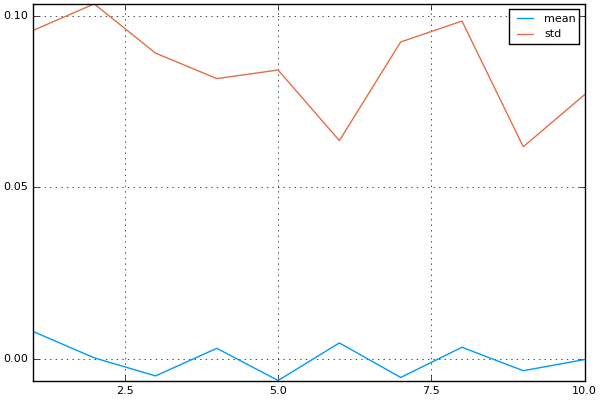

In [39]:
# plot mean and std
plot([ [mean(w2[:,i]) for i in 1:10] [std(w2[:,i]) for i in 1:10] ], legend=true, label=["mean" "std"])


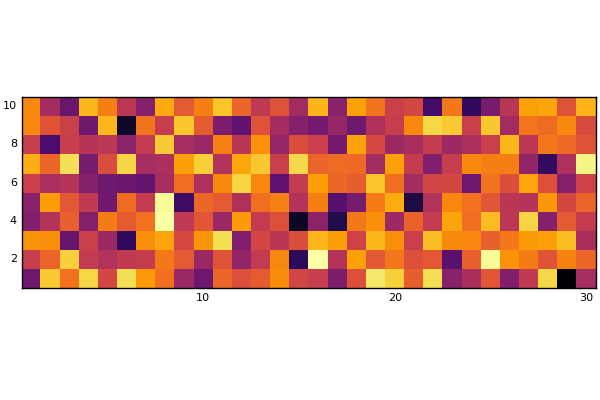

In [40]:
# plot them as 30x10 arrays
heatmap(reshape(w2[:,1], 10,30), aspect_ratio=:equal)

In [41]:
# switch to PyPlot because Plotly doesn't support clims attribute and I will want to compare later
pyplot()

Plots.PyPlotBackend()


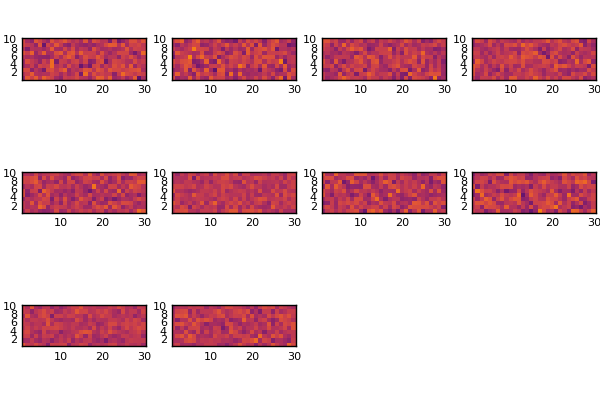

In [42]:
plot([heatmap(reshape(w2[:,i], 10,30), aspect_ratio=:equal, clims=(-0.6,0.6)) for i=1:10]...)

## Train model 10 epochs 

Ok.  Let's run it for a few epochs and watch what happens.  Note that every time we call `fit()`, the default is to continue training the same model without resetting the weights. 

In [43]:
@time mx.fit(model, optimizer, train_provider, eval_data=eval_provider, n_epoch=9)

INFO: Start training on MXNet.mx.Context[CPU0]
INFO: Initializing parameters...
INFO: Creating KVStore...
INFO: TempSpace: Total 4 MB allocated on CPU0
INFO: Start training...
INFO: == Epoch 001/009 ==========
INFO: ## Training summary
INFO:           accuracy = 0.8643
INFO:               time = 9.1088 seconds
INFO: ## Validation summary
INFO:           accuracy = 0.8391
INFO: == Epoch 002/009 ==========
INFO: ## Training summary
INFO:           accuracy = 0.9066
INFO:               time = 8.3779 seconds
INFO: ## Validation summary
INFO:           accuracy = 0.9173
INFO: == Epoch 003/009 ==========
INFO: ## Training summary
INFO:           accuracy = 0.9159
INFO:               time = 8.7162 seconds
INFO: ## Validation summary
INFO:           accuracy = 0.9248
INFO: == Epoch 004/009 ==========
INFO: ## Training summary
INFO:           accuracy = 0.9223
INFO:               time = 8.3265 seconds
INFO: ## Validation summary
INFO:           accuracy = 0.9298
INFO: == Epoch 005/009 =========

In [44]:
# let's examine how the weights in the hidden layer have changed after 10 more epochs of training
w211 = copy(model.arg_params[:fc2_weight])

300×10 Array{Float32,2}:
 -0.18999      0.0523741    0.0521278    …   0.256539     0.0830147 
 -0.0566305   -0.0292824    0.000472053     -0.176414    -0.137913  
 -0.0510069   -0.15316     -0.15406         -0.00278085  -0.175738  
 -0.160078     0.0158039    0.0645762        0.101266     0.0279298 
 -0.121867     0.126162     0.203941        -0.0970455    0.1576    
 -0.27373     -0.234331     0.03053      …  -0.02137      0.0339543 
  0.165604    -0.171726    -0.0604989        0.0526133   -0.0206003 
 -0.0281766    0.0293302    0.0430013       -0.0955367   -0.137775  
  0.126382    -0.076785     0.10942          0.0555131   -0.0920628 
  0.128483     0.0501477    0.136502         0.0789185   -0.133262  
  0.211869    -0.153832    -0.119128     …   0.0677559    0.0706252 
  0.0836029    0.188536    -0.144794        -0.05817     -0.049355  
  0.156777    -0.0915638   -0.21475          0.0954725    0.209062  
  ⋮                                      ⋱                          
  0.08554

In [45]:
# extrema mean and standard deviation for each of the 10 groups
[ [extrema(w211[:,i]) for i in 1:10] [mean(w211[:,i]) for i in 1:10] [std(w211[:,i]) for i in 1:10] ]

10×3 Array{Any,2}:
 (-0.357168,0.36403)    0.00906962   0.144172
 (-0.291686,0.346591)   0.000505016  0.124114
 (-0.35688,0.567968)   -0.00167273   0.145727
 (-0.354625,0.29979)    0.0025032    0.126793
 (-0.335417,0.335986)  -0.0121043    0.133443
 (-0.61578,0.406012)    0.0105811    0.144681
 (-0.34189,0.273747)   -0.00809373   0.127449
 (-0.443309,0.390159)   0.00113069   0.145592
 (-0.423108,0.589517)  -0.00721869   0.125767
 (-0.339918,0.404306)   0.00526154   0.132497


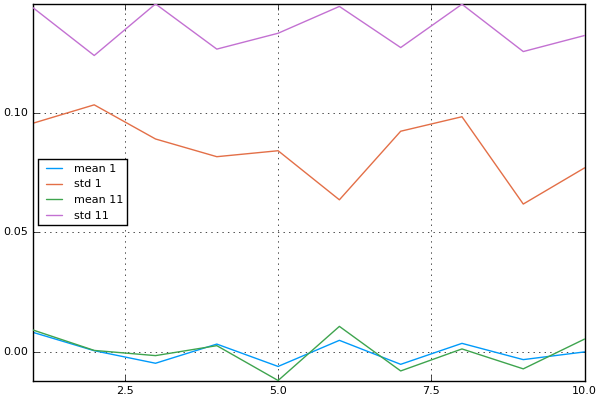

In [46]:
# plot comparison to previous 
plot([ [mean(w2[:,i]) for i in 1:10] [std(w2[:,i]) for i in 1:10] [mean(w211[:,i]) for i in 1:10] [std(w211[:,i]) for i in 1:10] ], 
label=["mean 1" "std 1" "mean 10" "std 10"], legend=true)


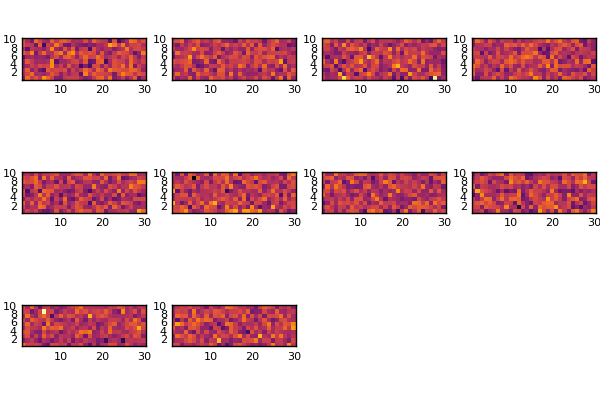

In [47]:
plot([heatmap(reshape(w211[:,i], 10,30), aspect_ratio=:equal, clims=(-0.6,0.6)) for i=1:10]...)

In [48]:
# test on eval set
preds = mx.predict(model, eval_provider)
correct = 0
for i = 1:size(preds)[2]
    if indmax(preds[:,i]) == eval_y[i]+1
        correct += 1
    end
end
correct/size(preds)[2]

INFO: TempSpace: Total 1 MB allocated on CPU0


The accuracy already seems to be stabilizing around 95%, but we will run a few more epochs to see what happens

## Train model 20 epochs 

In [49]:
@time mx.fit(model, optimizer, train_provider, eval_data=eval_provider, n_epoch=10)

INFO: Start training on MXNet.mx.Context[CPU0]
INFO: Initializing parameters...
INFO: Creating KVStore...
INFO: TempSpace: Total 4 MB allocated on CPU0
INFO: Start training...
INFO: == Epoch 001/010 ==========
INFO: ## Training summary
INFO:           accuracy = 0.9494
INFO:               time = 8.3934 seconds
INFO: ## Validation summary
INFO:           accuracy = 0.9477
INFO: == Epoch 002/010 ==========
INFO: ## Training summary
INFO:           accuracy = 0.9522
INFO:               time = 8.7644 seconds
INFO: ## Validation summary
INFO:           accuracy = 0.9524
INFO: == Epoch 003/010 ==========
INFO: ## Training summary
INFO:           accuracy = 0.9553
INFO:               time = 8.9129 seconds
INFO: ## Validation summary
INFO:           accuracy = 0.9527
INFO: == Epoch 004/010 ==========
INFO: ## Training summary
INFO:           accuracy = 0.9586
INFO:               time = 8.4194 seconds
INFO: ## Validation summary
INFO:           accuracy = 0.9558
INFO: == Epoch 005/010 =========

 93.436206 seconds (3.92 M allocations: 2.322 GB, 6.35% gc time)


INFO:           accuracy = 0.9629
INFO: Finish training on MXNet.mx.Context[CPU0]


It looks like it might have improved to 97%, but that is on the eval set.  Let's go ahead and make predictions with the model we have trained using the Kaggle test set and create a file that can be submitted on the website.  Note that running a prediction is a lot faster than training.

## run on test set

In [50]:
@time test = readtable("data/test.csv");

 26

In [51]:
size(test)

(28000,784)

In [52]:
test_X = transpose(Array(test))

784×28000 Array{Int64,2}:
 0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0   0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0   0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0   0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0   0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0   0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0   0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0   0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0   0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0   0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0   0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0   0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0   0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0


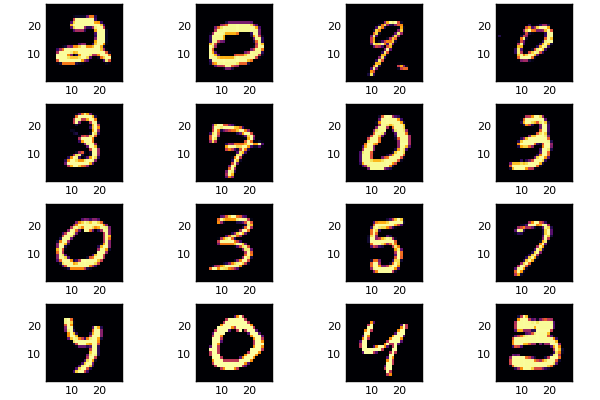

In [53]:
plot([heatmap(rotl90(reshape(Array(test_X[1:end,i]), 28, 28)), aspect_ratio=:equal) for i=1:16]...)

In [54]:
extrema(test_X)

(0,255)

In [55]:
mean(test_X)

33.3515450983965

In [56]:
# scale test_X to range 0-1
test_X = test_X./255;

In [57]:
test_provider = mx.ArrayDataProvider(test_X, batch_size=batch_size, shuffle=false)

MXNet.mx.ArrayDataProvider(Array{Float32,N}[
Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]],Symbol[:data],Array{Float32,N}[],Symbol[],1000,28000,false,0.0f0,0.0f0,MXNet.mx.NDArray[mx.NDArray{Float32}(784,1000)],MXNet.mx.NDArray[])

In [58]:
# this uses the previously trained model and the DataProvider specified above
@time tpreds = mx.predict(model, test_provider)

INFO: TempSpace: Total 1 MB allocated on CPU0


  4.253657 seconds (20.44 k allocations: 86.709 MB, 10.64% gc time)


10×28000 Array{Float32,2}:
 3.32992f-5   0.998368     1.43607f-5   …  1.062f-6     2.4091f-5  
 1.16891f-10  3.90927f-8   0.000117007     1.37874f-8   2.84631f-9 
 0.999818     0.000398155  7.91866f-5      5.73282f-7   0.999624   
 0.00013095   1.55586f-5   0.000858953     0.00192545   0.000157291
 7.27301f-7   1.95835f-9   0.0574737       0.0149685    6.15969f-5 
 2.27206f-7   0.00120688   0.00746393   …  0.000177767  1.21758f-5 
 2.64876f-7   7.05455f-6   1.17546f-5      1.13237f-7   5.25664f-6 
 8.56755f-7   3.20001f-6   0.00172127      0.000133627  7.38207f-8 
 1.45219f-5   1.30237f-6   0.0118794       7.05102f-5   0.000103447
 1.1988f-6    2.87172f-7   0.92038         0.982722     1.20239f-5 

In [59]:
# create submission
open("MLP1submission.csv", "w") do f
    write(f, "ImageId,Label\n")
    for i = 1:size(tpreds)[2]
        write(f, string(i),",",string(indmax(tpreds[:,i])-1),"\n")
    end
end

When I submit the resulting file to https://kaggle.com/c/digit-recognizer/submit, I get a score of 0.95200.  which is pretty close to the error rate of 4.7% reported above for this network.  The validation accuracy was just beginning to plateau so it isn't clear if we could get a little more out of training, but I'm more interested here in demonstrating creating the two layer network.  We will duplicate the 300-100 net that got an error rate of 4.5%.

# MLP - two layer

Here we define a new, two layer network with two FullyConnected Layers and tanh activations.  We could use code similar to last time:
```
data = mx.Variable(:data)
fc1 = mx.FullyConnected(data, name=:fc1, num_hidden=300)
act1 = mx.Activation(fc1, name=:relu1, act_type=:relu)
fc2 = mx.FullyConnected(act1, name=:fc2, num_hidden=100)
act2 = mx.Activation(fc2, name=:relu2, act_type=:relu)
fc3 = mx.FullyConnected(act2, name=:fc3, num_hidden=10)
mlp2 = mx.SoftmaxOutput(fc3, name=:softmax)
```
but, to demonstrate a shortcut, we will use the MXNet chain macro to create this net using `=>` connections.

In [60]:
# define new network
mlp2 = @mx.chain mx.Variable(:data) => 
 mx.FullyConnected(name=:fc1, num_hidden=300) =>
mx.Activation(name=:tanh1, act_type=:tanh) =>
 mx.FullyConnected(name=:fc2, num_hidden=100) =>
mx.Activation(name=:tanh2, act_type=:tanh) =>
 mx.FullyConnected(name=:fc3, num_hidden=10) =>
 mx.SoftmaxOutput(name=:softmax)

MXNet.mx.SymbolicNode(MXNet.mx.MX_SymbolHandle(Ptr{Void} @0x000000001cfa0a10))

## Display model

In [61]:
# save file - note that the `do` block automatically closes the filestream
open("mlp2graph.dot", "w") do fs
    print(fs, mx.to_graphviz(mlp2))
end

In [62]:
# we can run the `dot` program to convert to png if it is installed on your computer
run(pipeline(`dot -Tpng mlp2graph.dot`, stdout="mlp2graph.png"))

We can display this file:
![mlp2graph.png](mlp2graph.png)

In [63]:
# change context to gpu(number) if you have a gpu
model = mx.FeedForward(mlp2, context=mx.cpu())

MXNet.mx.FeedForward(MXNet.mx.SymbolicNode(MXNet.mx.MX_SymbolHandle(Ptr{Void} @0x000000001cfa0a10)),MXNet.mx.Context[CPU0],#undef,#undef,#undef)

## Train model

In [64]:
@time mx.fit(model, optimizer, train_provider, eval_data=eval_provider, n_epoch=20)

INFO: Start training on MXNet.mx.Context[CPU0]
INFO: Initializing parameters...
INFO: Creating KVStore...
INFO: TempSpace: Total 4 MB allocated on CPU0
INFO: Start training...
INFO: == Epoch 001/020 ==========
INFO: ## Training summary
INFO:           accuracy = 0.1096
INFO:               time = 11.8936 seconds
INFO: ## Validation summary
INFO:           accuracy = 0.1056
INFO: == Epoch 002/020 ==========
INFO: ## Training summary
INFO:           accuracy = 0.3144
INFO:               time = 12.0328 seconds
INFO: ## Validation summary
INFO:           accuracy = 0.5613
INFO: == Epoch 003/020 ==========
INFO: ## Training summary
INFO:           accuracy = 0.7609
INFO:               time = 12.0750 seconds
INFO: ## Validation summary
INFO:           accuracy = 0.8576
INFO: == Epoch 004/020 ==========
INFO: ## Training summary
INFO:           accuracy = 0.8721
INFO:               time = 11.7286 seconds
INFO: ## Validation summary
INFO:           accuracy = 0.8989
INFO: == Epoch 005/020 =====

282.506040 seconds (8.59 M allocations: 4.680 GB, 4.63% gc time)


After 20 epochs of training, we seem to be hitting a ceiling on validation accuracy.  Let's use this newly trained model to predict on the test set and submit to Kaggle.

In [65]:
# this uses the recently trained model and the same DataProvider on the test set 
@time tpreds = mx.predict(model, test_provider)

INFO: TempSpace: Total 1 MB allocated on CPU0


  3.578575 seconds (5.62 k allocations: 86.121 MB, 0.41% gc time)


10×28000 Array{Float32,2}:
 3.17956f-5   0.999099     1.12871f-6   …  1.32057f-6   6.29556f-6 
 5.82953f-8   1.96553f-8   0.000100165     3.53726f-8   1.18404f-7 
 0.99966      0.000367172  1.80263f-6      1.26685f-6   0.999141   
 0.000230099  1.24621f-6   8.82856f-5      0.0032008    0.000576255
 5.89889f-6   1.49464f-7   0.0208702       0.0349224    5.21555f-5 
 1.43514f-7   0.000451465  0.000577244  …  0.000289193  7.39706f-7 
 9.90732f-7   7.13181f-5   6.17309f-7      2.8054f-7    1.98969f-6 
 1.8722f-5    4.91723f-6   0.000499786     0.00010417   4.51312f-6 
 5.00769f-5   1.48886f-6   0.00483644      0.000480367  0.00021646 
 1.78278f-6   3.23831f-6   0.973024        0.961        1.00423f-6 

In [66]:
# create submission
open("MLP2submission.csv", "w") do f
    write(f, "ImageId,Label\n")
    for i = 1:size(tpreds)[2]
        write(f, string(i),",",string(indmax(tpreds[:,i])-1),"\n")
    end
end

When I submit this new file to Kaggle, I get a score of 0.95657, which is similar to the error of 4.5% from the LeCun paper. Creating MLPs is very easy with MXNet and there is even an `MLP()` constructor.  The equivalent code for this is:
```
mlp2 = @mx.chain mx.Variable(:data) =>
  mx.MLP([300, 100, 10]) =>
  mx.SoftmaxOutput(name=:softmax)
```
Running this model for 20 epochs and submitting to Kaggle got me a better score of 0.96543.  I'm not sure why yet, although the defaults for this constructor are different.  For example, `MLP()` defaults to using `:relu` activations which have become more standard as they are faster than the original `:tanh` activations I used.  ReLU do have problems at zero due to the discontinuity there, so other variants like LeakyReLU have been developed as mentioned above.

I hope this notebook has been helpful.  Please leave a comment if you have suggestions for improvement.

[<img style="float: left;" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png">](http://creativecommons.org/licenses/by-sa/4.0/)  

Licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).